In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel # Feature selector
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import stats, uniform, randint
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # The k-nearest neighbor classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import *
from sklearn import feature_selection
from sklearn.utils.class_weight import compute_class_weight

from helper import helper

## Preguntas 4 y 5

In [18]:
df = pd.read_csv('Challenge_LATAM/custom_df.csv')
df.head(3)

,Unnamed: 0,dif_min,atraso_15,temporada_alta,periodo_dia,cambio_aerolinea,cambio_num_vuelo,same_destination,TIPOVUELO_I,OPERA_Aerolineas Argentinas,...,SIGLADES_Montevideo,SIGLADES_Nueva York,SIGLADES_Other,SIGLADES_Paris,SIGLADES_Puerto Montt,SIGLADES_Punta Arenas,SIGLADES_Rio de Janeiro,SIGLADES_Sao Paulo,SIGLADES_Temuco,SIGLADES_Valdivia
0,0,3.0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9.0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,9.0,0,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
helper.dropcol(df, ['Unnamed: 0'])

Preparamos el dataset para el modelo

In [23]:
y = df['atraso_15']
X = df.drop(['atraso_15', 'dif_min'], axis=1)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=20, stratify=y)
# stratify = y because it's an imbalanced dataset

#### Métrica utilizada

Para determinar cuál es el modelo que mejor performa, hemos elegido la métrica de recall. 

$$ Recall\: \frac{TP}{TP + FN } $$

El recall se centra en los True Positives - es decir, se utiliza para saber cuantos Verdaderos Positivos son correctamente clasificados por el modelo. 
En nuestro caso, es más importante que el modelo identifique como vuelos atrasados todos los vuelos que realmente se han atrasado, ya que entendemos que los FN (predecir vuelo como no atrasado cuando en realidad es atrasado) puede tener un impacto negativo en el cliente. 

También vamos a centrarnos en f1_score micro.
F1 Score es una métrica que combina el precision y el recall. 
$$ F1\ = 2 * \frac{recall * precision }{recall + precision } $$
Micro-average se prefiere cuando hay un class imbalance.

En Micro-average method:hace una media global del F1 score contando las sumas de los TP, FN y FP. 

## Modelos de Clasificación

#### 1. Random Forest

Random Forest es una metodología de bagging donde, seleccionando un subset de features, el método es capaz de capturar el impacto de las diferentes variables, llevando al modelo a tener un gran poder predictivo. 

Hay varios hiperparámetros en el modeo que tenemos que tunear, acorde a la data y ss características. 

Es importante resaltar que una de las características de los tree-based models, es que son eficientes en el manejo de variables categóricas y de data no-normalizada - creando modelos interpretables. 

Usamos class_weight = 'balanced' ya que se trata de un imbalanced dataset.

Vamos a crear a entrenar el Random Forest con la data normalizada (usando StandardScaler) y no normalizada, y comparareros ambos resultados. 

In [7]:
# Random Forest
rf_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestClassifier(class_weight='balanced', random_state = 42)),
                        ])

rf_pipe =  Pipeline([
                ('clf', RandomForestClassifier(class_weight='balanced', random_state = 42)),
                        ])
                        
param_range = [3, 4, 5, 6, 7, 8, 9, 10, 11]
param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]


grid_params_rf = [{'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_leaf': param_range,
        'clf__max_depth': param_range,
        'clf__min_samples_split': param_range}]

# Randomized Search
n_jobs = -1 #n_jobs to run faster
skf = StratifiedKFold(n_splits=10)

gs_rf_scl = RandomizedSearchCV(estimator= rf_pipe_scl, 
                           param_distributions=grid_params_rf, 
                           scoring = "recall",
                           cv= skf) 

gs_rf = RandomizedSearchCV(estimator= rf_pipe, 
                           param_distributions=grid_params_rf, 
                           scoring = "recall",
                           cv= skf) 

grids = [gs_rf_scl, gs_rf]

# Dictionary of pipelines and classifier types for reference 
grid_dict = {0: 'Random Forest with Scaling', 1: 'Random Forest'}

# Fit the grid search 
print("Training model...")

best_recall = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training recall Score
    print('Best training recall Score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data recall of model with best params
    print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))
    # Track best (highest test recall) model
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\nClassifier with best test set recall_score: %s' % grid_dict[best_clf])

print('classifiers trained!')

Training model...

Estimator: Random Forest with Scaling
Best params: {'clf__min_samples_split': 7, 'clf__min_samples_leaf': 9, 'clf__max_depth': 6, 'clf__criterion': 'entropy'}
Best training recall Score: 0.684
Test set recall score for best params: 0.699 

Estimator: Random Forest
Best params: {'clf__min_samples_split': 11, 'clf__min_samples_leaf': 8, 'clf__max_depth': 7, 'clf__criterion': 'entropy'}
Best training recall Score: 0.687
Test set recall score for best params: 0.679 

Classifier with best test set recall_score: Random Forest with Scaling
classifiers trained!


Random Forest con mejores hiperparámetros: 

In [25]:
rfc = Pipeline([('scl', StandardScaler()),
                ('clf', RandomForestClassifier(class_weight='balanced',min_samples_split= 7,min_samples_leaf=9, max_depth=7, criterion='entropy', random_state=42)),
                        ]) 


rfc.fit(X, y)

y_pred = rfc.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')


The recall is: 0.6812896405919662
The f1 micro score is: 0.5981331248167334
The f1 macro score is: 0.5434251972707762


##### Matriz de Confusión

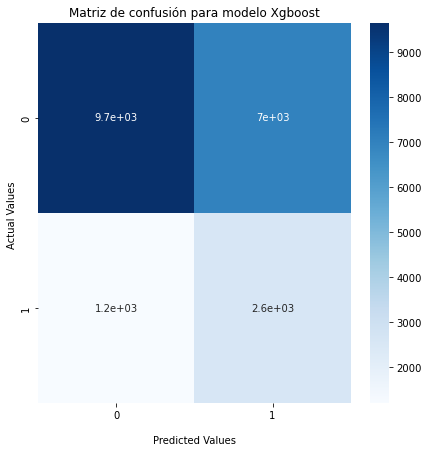

In [14]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_ylabel('Actual Values ');


##### Random Forest Feature importance: 
Vamos a hacer el feature importance sobre el otro modelo random forest (sin scaling) ya que tuvo resultados muy similares al de Random Forest con scaling


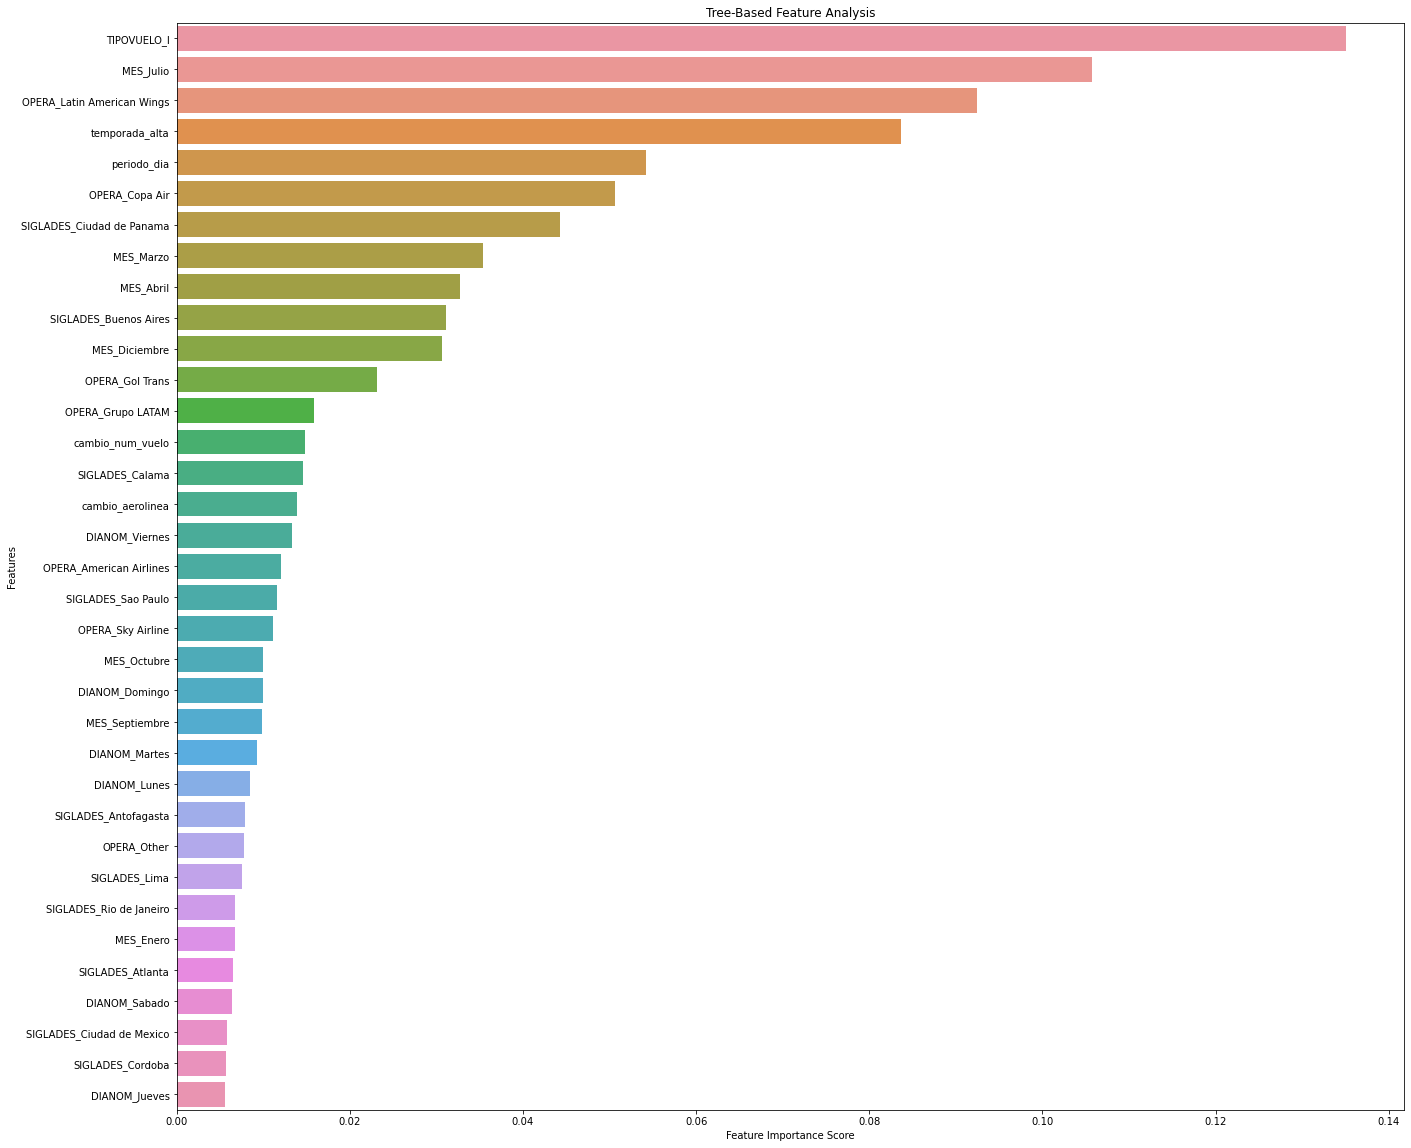

In [17]:
rfc = RandomForestClassifier(class_weight='balanced',min_samples_split = 11, min_samples_leaf = 8, max_depth = 7, criterion = 'entropy', random_state=42)

rfc.fit(X, y)

feature_scores = pd.Series(rfc.feature_importances_, index=X.columns).sort_values(ascending=False).head(35)
sns.barplot(x=feature_scores, y=feature_scores.index).set_title('Tree-Based Feature Analysis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.rcParams["figure.figsize"] = (22, 20)

Las 10 variables que más influyen en el atraso del vuelo según el modelo de Random Forest son: 
- TIPOVUELO_I : si el vuelo es internacional o nacional
- MES_JULIO : si el vuelo es en el mes de Julio o no
- temporada_alta : si el vuelo es en temporada alta o no 
- OPERA_Latin American Wings: si la aerolinea que opera es Latin American Wings
- periodo_dia : si el vuelo es por la mañana, tarde o noche
- OPERA_Copa Air: si la aerolinea que opera es Copa Air
- SIGLADES_Ciudad de Panama: si el destino del vuelo es Ciudad de Panamá
- MES_MARZO: Si el vuelo es en el mes de Marzo o no
- MES_ABRIL: Si el vuelo es en el mes de Abril o no
- SIGLADES_Buenos Aires: si el destino del vuelo es Buenos Aires

##### Conclusión Modelo Random Forest

Con este modelo obtenemos un recall de 68.12%. 

Podemos obtener el feature importance gracias a la buena interpretabilidad del modelo. Vemos que las variables que más influyen en el atraso de los vuelos son: si el vuelo es nacional/internacional, si el vuelo es en el mes de Julio (como vimos, es un mes de temporada alta), si el vuelo es en temporada alta o no y si la aerolinea que opera es Latin American Wings. 


#### 2. XGBoost

Gradient boosting es una metodología ensemble en la que en cada iteración el nuevo predictor se construye para ajustarse a los pseudo-residuales del predictor anterior. El proceso de boosting tiene como objetivo reducir el bias y la varianza. 

Este modelo no puede manejar variables categóricas, con lo que una feature transformation es necesaria para incorporar variables ctegóricas al modelo. XGB no necesita otra feature transformation, como scaling o imputación de missing values. 

Vamos a definir el scale_pos_weight ya que se trata de un dataset imbalanceado. 

In [28]:
# We define scale_pos_weight (imbalanced dataset)
total_negative_examples = len(df[df['atraso_15']==0])
total_positive_examples = len(df[df['atraso_15']==1])
scale_pos_weight = total_negative_examples / total_positive_examples

In [20]:
xgb_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)),
                        ])

xgb_pipe = Pipeline([
                ('clf', XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42)),
                        ])

grid_params_xgb = [{
    'clf__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5], # Minimum loss reduction to make the split
    'clf__max_depth': [3, 5, 7, 10], # The maximum level of splits from where the model prunes backwards in terms of info. gain
    'clf__n_estimators': [100,300,500,700], # Number of boosting rounds 
    'clf__subsample': [0.5, 0.6, 0.7, 0.8, 0.9] # Start value - typical values are 0.5-0.9
}]

skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_xgb_scl = RandomizedSearchCV(estimator= xgb_pipe_scl, 
                           param_distributions=grid_params_xgb, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

gs_xgb = RandomizedSearchCV(estimator= xgb_pipe, 
                           param_distributions=grid_params_xgb, 
                           scoring = "recall",
                           cv= skf, n_jobs=n_jobs) 

grids = [gs_xgb_scl, gs_xgb]

# Dictionary of pipelines and classifier types for reference 
grid_dict = {0: 'XGB with Scaling', 1: 'XGB'}

# Fit the grid search 
print("Training model...")

best_recall = 0.0
best_clf = 0
best_gs = ''
for idx, gs in enumerate(grids):
    print('\nEstimator: %s' % grid_dict[idx])
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print('Best params: %s' % gs.best_params_)
    # Best training recall Score
    print('Best training recall Score: %.3f' % gs.best_score_)
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data recall of model with best params
    print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))
    # Track best (highest test recall) model
    if recall_score(y_test, y_pred) > best_recall:
        best_recall = recall_score(y_test, y_pred)
        best_gs = gs
        best_clf = idx
        
print('\nClassifier with best test set recall_score: %s' % grid_dict[best_clf])

print('classifiers trained!')

Training model...

Estimator: XGB with Scaling


C:\Users\rebeccah.cohen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'clf__subsample': 0.9, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__gamma': 0.1}
Best training recall Score: 0.646
Test set recall score for best params: 0.655 

Estimator: XGB


C:\Users\rebeccah.cohen\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[03:46:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'clf__subsample': 0.5, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__gamma': 0.3}
Best training recall Score: 0.646
Test set recall score for best params: 0.652 

Classifier with best test set recall_score: XGB with Scaling
classifiers trained!


XGB con mejores hiperparámetros:

In [32]:
xgb = Pipeline([('scl', StandardScaler()),
                ('clf', XGBClassifier(scale_pos_weight = scale_pos_weight, random_state = 42, subsample = 0.9, n_estimators = 100, max_depth = 3, gamma = 0.1, use_label_encoder=False)),
                        ])

xgb.fit(X, y)

y_pred = xgb.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')

[08:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
The recall is: 0.6791754756871036
The f1 micro score is: 0.647541784771772
The f1 macro score is: 0.5818559956521077


##### XGB Feature importance: 
Vamos a hacer el feature importance sobre el otro modelo XGB (sin scaling) ya que tuvo resultados muy similares en el Randomized Search al de XGB con scaling

[08:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


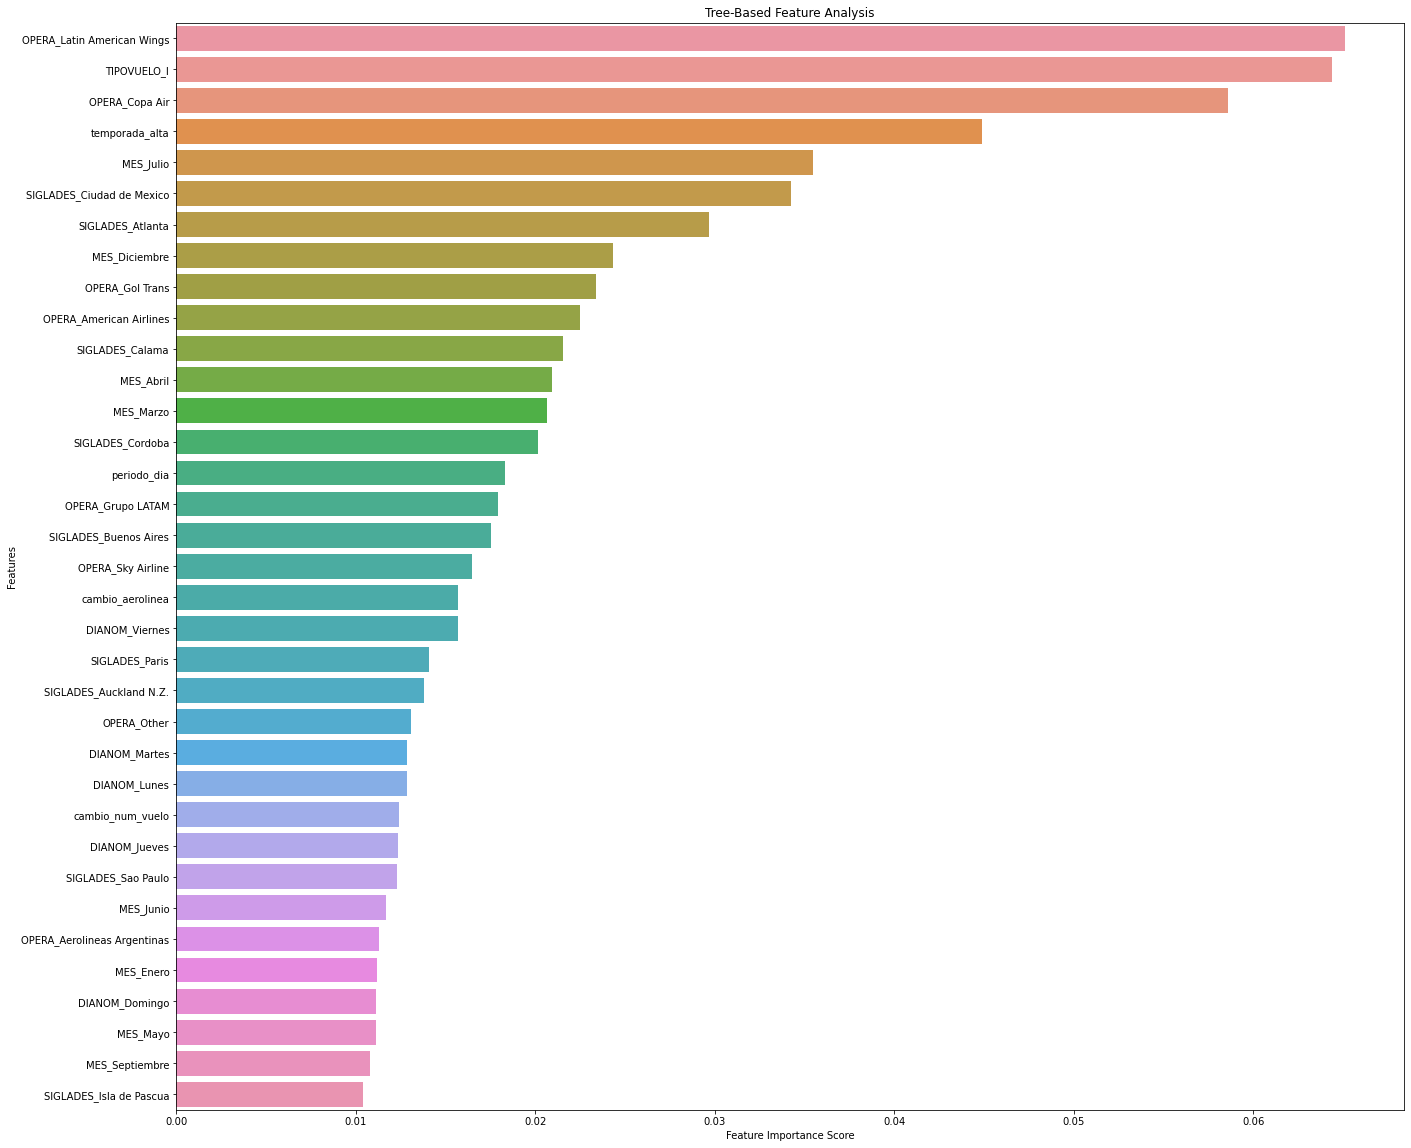

In [36]:
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, subsample= 0.5, n_estimators= 100, max_depth= 3, gamma= 0.3, random_state=42, use_label_encoder=False)

xgb.fit(X, y)

feature_scores = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False).head(35)
sns.barplot(x=feature_scores, y=feature_scores.index).set_title('Tree-Based Feature Analysis')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.rcParams["figure.figsize"] = (22, 20)

Las 10 variables que más influyen en el atraso del vuelo según el modelo de XGB son: 
- OPERA_Latin American Wings: si la aerolinea que opera es Latin American Wings
- TIPOVUELO_I : si el vuelo es internacional o nacional
- OPERA_Copa Air: si la aerolinea que opera es Copa Air
- temporada_alta : si el vuelo es en temporada alta o no 
- MES_JULIO : si el vuelo es en el mes de Julio o no
- SIGLADES_Ciudad De Mexico: si el destino del vuelo es Ciudad de Mexico
- SIGLADES_Atlanta: Si el destino del vuelo es Atlanta
- MES_DICIEMBRE: si el vuelo es en el mes de Diciembre
- OPERA_Gol Trans: si la aerolinea que opera es Gol Trans
- OPERA_American Airlines: si la aerolinea que opera es American Airlines. 

##### Matriz de Confusión

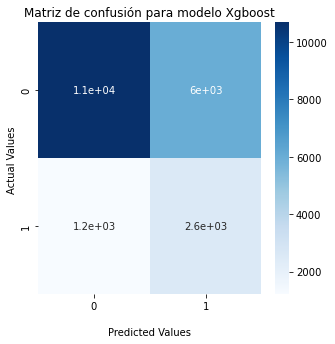

In [38]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.rcParams["figure.figsize"] = (5, 5)


##### Conclusión modelo XGBoost
Observamos resultados ligeramente peores a los del Random Forest, con un recall de 67.9% vs 68.12%. 

En cuanto al feature importance, vemos que la mayoría de variables más importantes son iguales para ambos modelos - XGB y Random Forest - siendo las variables que tienen más peso en XGB si la aerolinea es American Wings y si es un vuelo Nacional/Internacional. 

Cabe resaltar que la variable periodo_dia se encuentra entre las 10 variables más importantes en el modelo de RF y en el modelo de XGB ocupa la posición 15.

En cuanto a la matriz de confusión, vemos que el modelo XGB identifica más TN (true negatives: identifica vuelos no atrasados como no atrasados) que el modelo de RF, y el mismo numero de TP (true positives: identifica vuelos atrasados como atrasados). XGB identifica menos FP (false positives: identifica vuelos como atrasados cuando en realidad son no_atrasados) que el modelo de RF. 

#### 3. SVM - Support Vector Machine

El algoritmo SVM tiene como objetivo maximizar el "márgen máximo" de separación del hiperplano que separa las clases. En otras palabras, el objetivo del modelo es clasificar de forma efectiva los datos para que el modelo pueda generalizar mejor. 


Cuanto mayor sea la distancia entre los support vectors de los diferentes grupos, mayor será el márgen máximo de separación, y menor el error en la clasificación. Los modelos SVM tienen la opción de incluir kernels, lo que es útil cuando las clases no se pueden separar linearlmente.  

La data para SVM tiene que estar estandarizada, para poder diferenciar de manera eficiente entre las clases y aplicar correctamente las medidas de distancia.

In [18]:
svm_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', SVC(random_state = 42, class_weight = 'balanced')),
                        ])

param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]

grid_params_svm = [{
        'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
        'clf__C': param_range_fl
        }]


skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_svm_scl = RandomizedSearchCV(estimator= svm_pipe_scl, 
                           param_distributions=grid_params_svm, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

# Fit the grid search 
print("Training model...")

gs_svm_scl.fit(X_train, y_train)

print('Best params: %s' % gs_svm_scl.best_params_)
# Best training recall Score
print('Best training recall Score: %.3f' % gs_svm_scl.best_score_)
# Predict on test data with best params
y_pred = gs_svm_scl.predict(X_test)
# Test data recall of model with best params
print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))

print('classifier trained!')

Training model...
Best params: {'clf__kernel': 'rbf', 'clf__C': 0.01}
Best training recall Score: 0.642
Test set recall score for best params: 0.654 
classifier trained!


SVM con mejores hiperparámetros:

In [39]:
svc = Pipeline([('scl', StandardScaler()),
                ('clf', SVC(class_weight='balanced', random_state = 42, kernel='rbf', C=0.01)),
                        ])

svc.fit(X, y)

y_pred = svc.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')

The recall is: 0.6635835095137421
The f1 micro score is: 0.6036555566415795
The f1 macro score is: 0.5453070093296515


##### Matriz de confusión

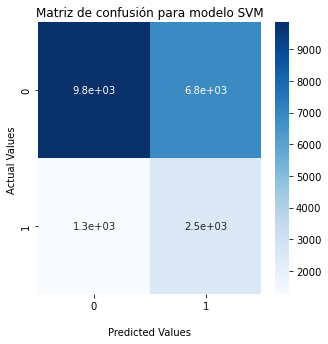

In [40]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo SVM');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.rcParams["figure.figsize"] = (5, 5)

##### Conclusión Support Vector Machines

Con SVM, obtenemos resultado peores a los 2 modelos anteriores, con un recall de 66.35%. 

En cuanto al feature importance, no podemos obtenerlo con SVM ya que es un modelo complejo y dificil de interpretar.

Mirando la matriz de confusión, vemos que el modelo SVM identifica más TN (true negatives) que el modelo de RF, y menos numero de TP (true positives), por lo que obtenemos un recall menor.

#### 4. Logistic Regression

El modelo de regresión logística es un modelo facil de interpretar y eficiente de entrenar a nivel computacional. Podemos saber el feature importance de las variables si miramos el peso de los coeficientes de la regresión logística. 

Este modelo asume que no hay multicolinearidad entre las variables X, es decir, que las variables tienen que ser todas independientes entre sí. 

In [57]:
logreg_pipe_scl = Pipeline([('scl', StandardScaler()),
                ('clf', LogisticRegression(class_weight='balanced', random_state = 42)),
                        ])

param_range_fl = [1.0, 0.7, 0.5, 0.3, 0.1, 0.01]

grid_params_logreg = [{
        'clf__penalty': ['l1','l2', 'none'],
        'clf__solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'], 
        'clf__C': param_range_fl
        }]


skf = StratifiedKFold(n_splits=10)
n_jobs = -1 #n_jobs to run faster

gs_logreg_scl = RandomizedSearchCV(estimator= logreg_pipe_scl, 
                           param_distributions=grid_params_logreg, 
                           scoring = "recall",
                           cv= skf, n_jobs = n_jobs) 

# Fit the grid search 
print("Training model...")

gs_logreg_scl.fit(X_train, y_train)

print('Best params: %s' % gs_logreg_scl.best_params_)
# Best training recall Score
print('Best training recall Score: %.3f' % gs_logreg_scl.best_score_)
# Predict on test data with best params
y_pred = gs_logreg_scl.predict(X_test)
# Test data recall of model with best params
print('Test set recall score for best params: %.3f ' % recall_score(y_test, y_pred))

print('classifiers trained!')

Training model...


C:\Users\rebeccah.cohen\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.60792752 0.60792752        nan 0.60792752
 0.60792752 0.60826727 0.60792752 0.60792752]
  warnings.warn(


Best params: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': 0.3}
Best training recall Score: 0.608
Test set recall score for best params: 0.614 
classifiers trained!


In [69]:
logreg = Pipeline([('scl', StandardScaler()),
                ('clf', LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.3, random_state=42)),
                        ]) 


logreg.fit(X, y)

y_pred = logreg.predict(X_test)
f1_score_macro = f1_score(y_test, y_pred, average='macro')
f1_score_micro = f1_score(y_test, y_pred, average='micro')

print(f'The recall is: {recall_score(y_test, y_pred)}')
print(f'The f1 micro score is: {f1_score_micro}')
print(f'The f1 macro score is: {f1_score_macro}')

The recall is: 0.6149577167019028
The f1 micro score is: 0.6292151304857785
The f1 macro score is: 0.5578428079701596


##### Matriz de Confusión

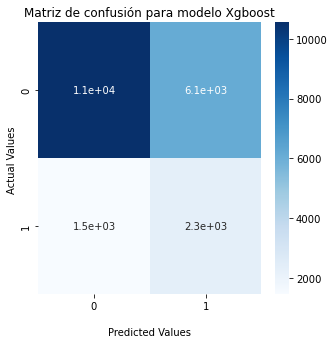

In [59]:
cf_matrix = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Matriz de confusión para modelo Xgboost');
ax.set_xlabel('\nPredicted Values')
plt.rcParams["figure.figsize"] = (5, 5)
ax.set_ylabel('Actual Values ');

##### Feature importance con Logistic Regression

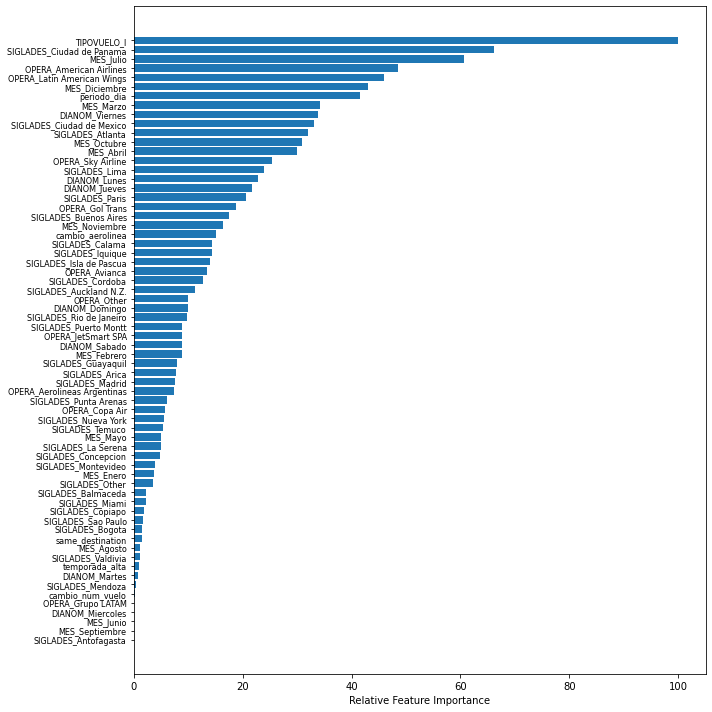

In [74]:
feature_importance = abs(logreg.named_steps['clf'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout() 
plt.rcParams["figure.figsize"] = (20, 10)  
plt.show()

Las 10 variables que más influyen en el atraso del vuelo según el modelo de Logistic Regression son: 
- TIPOVUELO_I : si el vuelo es internacional o nacional
- SIGLADES_Ciudad de Panamá: Si el destino del vuelo es Ciudad de Panamá
- MES_JULIO : si el vuelo es en el mes de Julio o no
- OPERA_American Airlines: si la aerolinea que opera es American Airlines. 
- OPERA_Latin American Wings: si la aerolinea que opera es Latin American Wings 
- MES_DICIEMBRE: si el vuelo es en el mes de Diciembre
- periodo_dia: si el vuelo es por la mañana, tarde o noche 
- MES_MARZO: si el vuelo es en el mes de marzo o no 
- DIANOM_Viernes: si el vuelo es el viernes 
- SIGLADES_Ciudad De Mexico: si el destino del vuelo es Ciudad de Mexico


##### Conclusión Logistic Regression

Observamos resultados  peores a los modelos anteriores , con un recall de 61.49%. 

En cuanto al feature importance, vemos que la mayoría de variables más importantes son iguales que para los modelos de XGB y Random Forest - siendo las variables que tienen más peso en Logistic Regression: si es un vuelo Nacional/Internacional o si el destino del vuelo es es Ciudad de Panamá. Hay que resaltar que la variable SIGLADES_Ciudad de Panamá no se encuentra entre las más importantes en el modelo de XGB pero sí en el de Random Forest. 

Resaltamos lo siguiente:
- DIANOM_Viernes se encuentra entre las más importantes en Logistic Regression y no en los otros dos modelos: XGB y RF. 
- OPERA_Copa Airline se encuentra entre las 10 variables más importantes en los modelos de RF y XGB y no en el de Logistic Regression. 

En cuanto a la matriz de confusión, vemos que el modelo de Logistic Regression identifica más TN (true negatives), menos TP (true positives) y más FN (False Negatives) que el modelo de RF, que es nuestro mejor modelo hasta ahora. Esto claramente afecta al recall, que es la métrica en la que nos estamos basando - ya que con el recall lo que pretendemos es evitar los Falsos Negativos (predecir que un vuelo no se atrasó cuando en realidad se atrasó)

## Posibles Mejoras

1. Hacer feature selection teniendo en cuenta el feature_importance de cada modelo, para tratar de meterle menos "ruido" al modelo y comprobar si mejora el recall, que, como vimos, es la métrica de precisión que vamos a utilizar. 
2. Probar con SMOTE o otro tipo de upsampling para imbalanced datasets. 
3. Recoger datos sobre el clima durante las fechas de los vuelos, ya que claramente es una variable que puede tener un gran impacto en el atraso de vuelos. Se entiende que los vuelos se pueden atrasar cuando hay condiciones meteorológicas adversas como fuertes vientos o nieve. 
4. Probar con diferentes scalings en los Pipeline - como Robust Scaling, que es más robusto a Outliers. 
5. Intentar otros modelos: LightGBM, KNN, AdaBoost, etc y comprobar si con esos modelos y un fine tuning obtenemos mejores métricas para el recall. 
6. Usar LSTM o modelos sARIMA para las variables temporales, ya que al usar LSTM podemos recordar la información pasada y, al predecir los valores futuros, tiene en cuenta esta información pasada.
7. La variable temporada_alta es una variable en la que gran parte de la variable "MES" está incluida, por lo que sería interesante probar los mismos modelos quitando la variable MES, y ver si mejora el recall